<a href="https://colab.research.google.com/github/Ratatoi/Trackify/blob/master/Single_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
path=pathlib.Path(base_dir+'Hospital/wheelchair_classif')

In [0]:
data = ImageDataBunch.from_folder(path,valid_pct=0.2,ds_tfms=get_transforms(),size=224,bs=64).normalize(imagenet_stats)

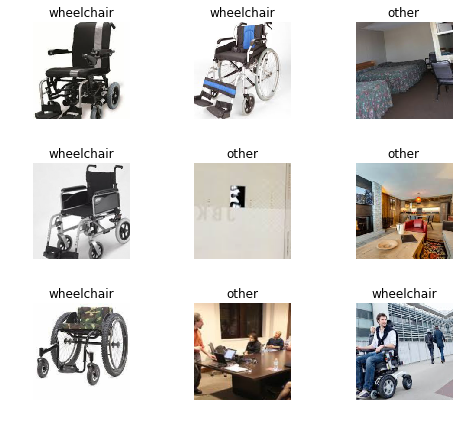

In [0]:
data.show_batch(rows=3, figsize=(7,6))

In [0]:
print(data.classes)
len(data.classes),data.c

['other', 'wheelchair']


(2, 2)

In [0]:
learn=cnn_learner(data,models.resnet34,metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:04<00:00, 20369646.95it/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.372527,0.041341,0.012448,03:36
1,0.189344,0.039683,0.012448,00:16
2,0.113650,0.033751,0.012448,00:16
3,0.083701,0.030956,0.008299,00:16


In [0]:
learn.save('wheelchair_classif_pre')

In [0]:
interp=ClassificationInterpretation.from_learner(learn)
losses,idxs=interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

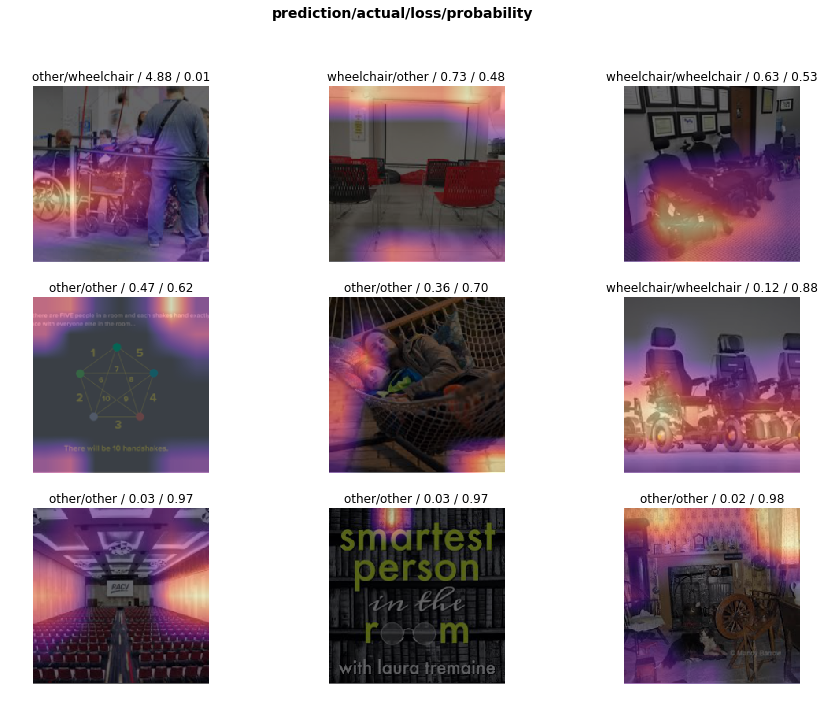

In [0]:
interp.plot_top_losses(9,figsize=(15,11))

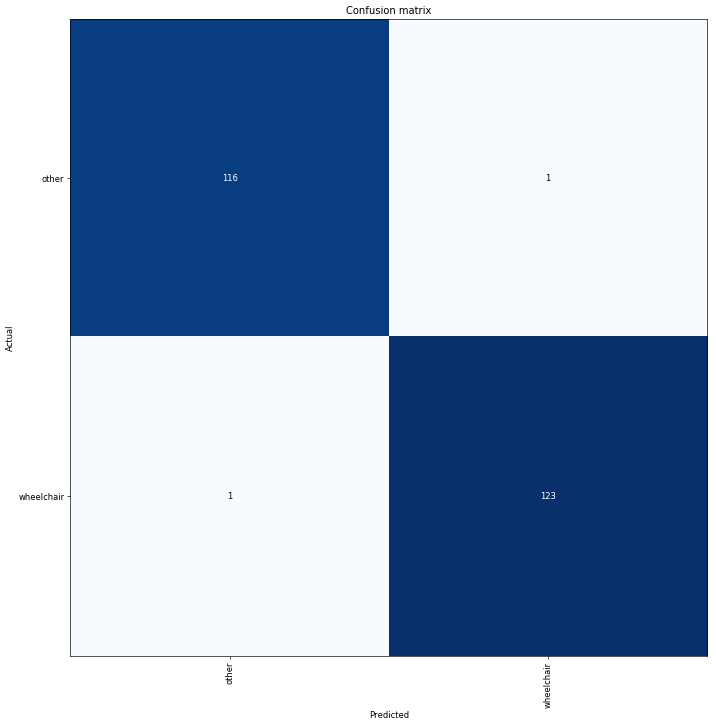

In [0]:
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [0]:
interp.most_confused(min_val=1)

[('other', 'wheelchair', 1), ('wheelchair', 'other', 1)]

In [0]:
len(data.valid_ds)

241

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


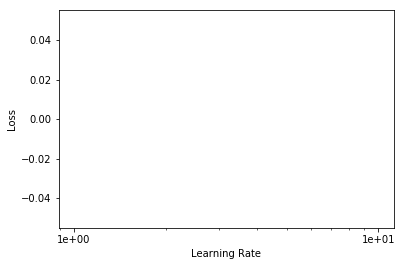

In [0]:
learn.recorder.plot()

In [0]:
learn.export(file='export_wheelchair_pre.pkl')

In [0]:
learn.unfreeze()
learn.fit_one_cycle(5,max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.025451,0.026974,0.004149,00:17
1,0.019707,0.022083,0.008299,00:17
2,0.015334,0.018430,0.008299,00:17
3,0.012530,0.014299,0.008299,00:17
4,0.011818,0.012792,0.004149,00:17


In [0]:
learn.save('wheelchair_classif_lr')

In [0]:
learn.load('wheelchair_classif_lr')

Learner(data=ImageDataBunch;

Train: LabelList (932 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bed,bed,bed,bed,bed
Path: /content/gdrive/My Drive/fastai-v3/Hospital/bed_classif;

Valid: LabelList (232 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
bed,other,bed,other,other
Path: /content/gdrive/My Drive/fastai-v3/Hospital/bed_classif;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (b

In [0]:
img=learn.data.train_ds[0][0]
learn.predict(img)

(Category bed, tensor(0), tensor([1.0000e+00, 1.9728e-07]))

In [0]:
path=pathlib.Path(base_dir+'Hospital')

In [0]:
learn.export(file='export_wheelchair_lr.pkl')

In [0]:
learn = load_learner(path/'wheelchair_classif', file = 'export_wheelchair_lr.pkl')
# learn = load_learner(path/'bed_classif', file = 'export.pkl')

In [0]:
fnames = get_image_files(path/'multi_classif/assets')
j=0
for i in fnames:
#   os.rename(path/'multi_classif/assets/images - 2019-06-18T101940.780.jpeg', path/'multi_classif/assets/train_1')
  os.rename(i, Path.joinpath(path/'multi_classif/assets','train_'+str(j)+'.jpeg'))
  j=j+1

In [33]:
%%time
tags = []
for i in fnames:
  img = open_image(i)
  out = learn.predict(img)
#   out_wheelchair = learn_wheelchair.predict(img)
  tags.append(str(out[0]))#append modifies list in place and returns none


CPU times: user 8.01 s, sys: 715 ms, total: 8.72 s
Wall time: 9.59 s


In [34]:
# Testing
img = open_image(path/'multi_classif/assets/images - 2019-06-18T101940.780.jpeg')
learn.predict(img)

(Category other, tensor(0), tensor([0.9719, 0.0281]))

In [0]:
# Run the first time to create csv file
# pred_dict = {'image_name':['train_0'],'tags':[str(out[0])]}# Put single item scalar values in a list
image_name = ['train_'+str(i) for i in range(len(tags))]
pred_dict = {'image_name':image_name,'tags':tags}
df = pd.DataFrame(pred_dict)
df.head()
df.to_csv(path/'multi_classif/train.csv')

In [53]:
# Read csv to update
df1 = pd.read_csv(path/'multi_classif/train_v1.csv', index_col = 0)#index col 0 to eliminate adding an unknown column
df1.head()

,image_name,tags
0,train_0,bed other
1,train_1,bed other
2,train_2,bed other
3,train_3,bed other
4,train_4,bed other


In [37]:
%time #To time execution
df_tags = list(df1['tags'])
df_tags = [ df_tags[i] +' ' + tags[i] for i in range(len(tags))]
df1['tags'] = df_tags
df1.head()

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


,image_name,tags
0,train_0,bed other
1,train_1,bed other
2,train_2,bed other
3,train_3,bed other
4,train_4,bed other


In [0]:
df1.to_csv(path/'multi_classif/train_v1.csv', index=False)# No index for multi classification